# Task 4

An important medical application of machine learning is image processing for image segmentation. Colonoscope images are frames taken from colonoscopy videos, and identifying whether polyps are present in a patient's colon is necessary for their removal to prevent potential colon cancer. Many models have been created for polyp recognition based on CVC-ClinicDB and achieved very high success rates.

**Sources:**

https://polyp.grand-challenge.org/CVCClinicDB/

https://paperswithcode.com/dataset/cvc-clinicdb

https://www.mayoclinic.org/diseases-conditions/colon-polyps/symptoms-causes/syc-20352875

https://paperswithcode.com/sota/medical-image-segmentation-on-cvc-clinicdb

## Evaluation Metrics

### Polyp Localization

One perfomance evaluation metric is detecting the location of the polyp within a given image frame. The dataset defines a ground truth region and a localization within this region is a true positive. A detection outside of this region is a false positive, and a polyp that was not detected is a false negative. The image below shows one true positive because one polyp was detected and correctly localized, but two false positives as two localizations fall outside the ground truth region.

For the competition, polyp localization metric is **Localization score (recall)** which is calculated by:

$\frac{\text{True Positives}}{\text{True Positives } + \text{ False Negatives}}$

The second metric is **Localization Precision**, which is calculated by:

$\frac{\text{True Positives}}{\text{True Positives } + \text{ False Positives}}$



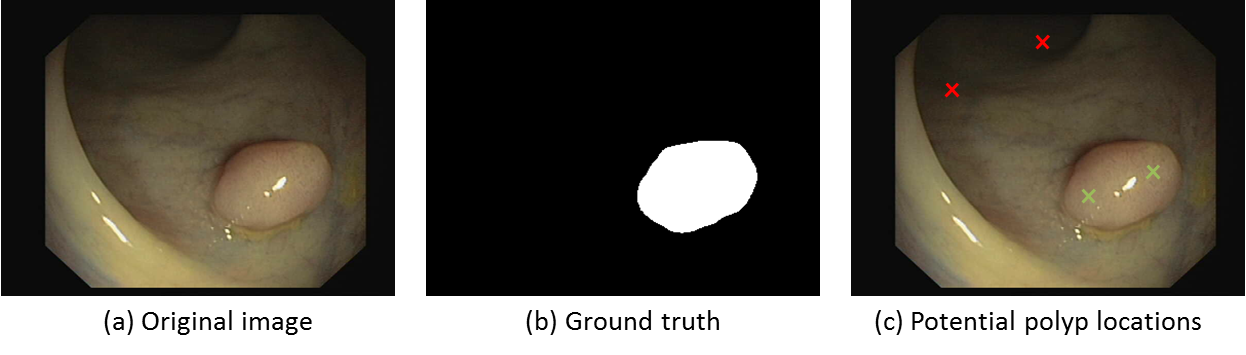

Image Source: https://polyp.grand-challenge.org/Metrics/

### Polyp Detection

The second goal is polyp detection, which focuses on whether a model can detect whether a polyp exists or does not exist during a video sequence. A true positive is detecting a polyp where there is a polyp, false positive is detecting a polyp where there is no polyp, and a false negative is failing to detect a polyp that exists.

The first metric is **Overall F-score**, which is calculated using the same precision and recall formulas as shown above:

$2 \cdot \frac{\text{Precision } \cdot \text{ Recall}}{\text{Precision } + \text{ Recall}}$


The **Average F-score** across all the videos is also calculated.

Because this metric is based in video processing, models also aim to achieve the lowest **Detection Latency** possible, which is calculated as:

$\frac{\text{# Frame First Detected } - \text{ # Frame Polyp Appeared}}{\text{Frame Rate}}$

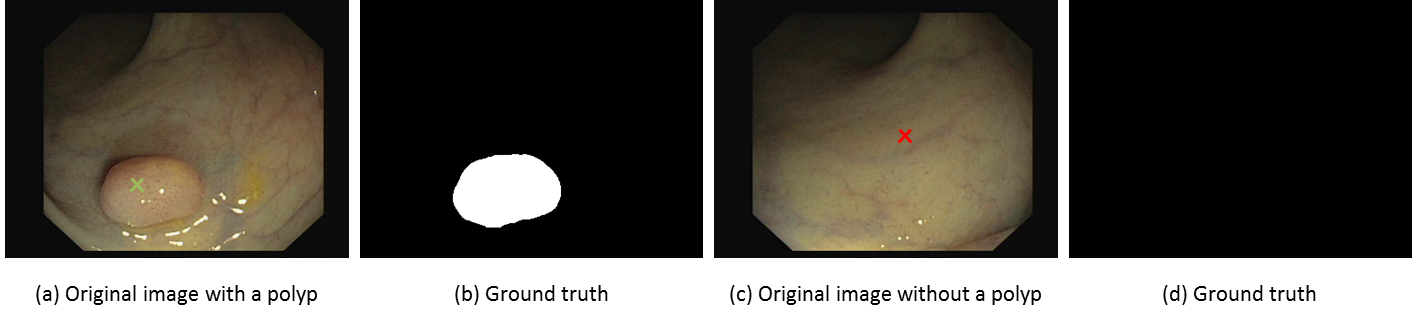

Image Source: https://polyp.grand-challenge.org/Metrics/

## Existing Models

### U-Net: Convolutional Networks for Biomedical Image Segmentation

U-Net is a convolutional neural network for image segmentation that used data augmentation to achieve better results with less training images. Published in 2015, U-net was faster and more precise than earlier models. On the CVC-ClinicDB dataset, U-net has a $0.8230$ Dice Similarity Coefficient, which was the highest score at the time. Since then, many models like U-Net++, DoubleU-Net, and ResUNet++ have built off of this original model to continue improving on the medical image segmentation problem and achieve higher scores. The original U-net architecture has 23 total convolutional layers, 18 convolutional layers using the ReLU activation function, and 5 for "up-convolution" that map back to the number of features. There are also 4 MaxPooling layers.

https://arxiv.org/pdf/1505.04597v1

### DUCK-Net

DUCK-Net holds the current highest Average Dice coefficient for the CVC-ClinicDB dataset at $0.9684$. DUCK-Net is a supervised neural network that uses an encoder-decoder structure, residual downsampling, a custom convolutional block, and data augmentation. The overall architecture is similar to U-net, but has its own convolutional blocks, a secondary downscaling layer and concatenates output to compute parameters faster and with less memory. DUCK-Net uses the RMSprop optimizer and directly uses Dice loss as a loss function.

https://www.nature.com/articles/s41598-023-36940-5

## U-Net Implementation

https://arxiv.org/pdf/1505.04597v1

https://paperswithcode.com/paper/-net-convolutional-networks-for-biomedical#code

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import rarfile
import os

### Dataset

In [93]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/cvcclinicdb")

print("Path to dataset files:", path)

100%|██████████| 131M/131M [00:01<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1


In [103]:
os.path.exists('/root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1/PNG/Original/1.png')

True

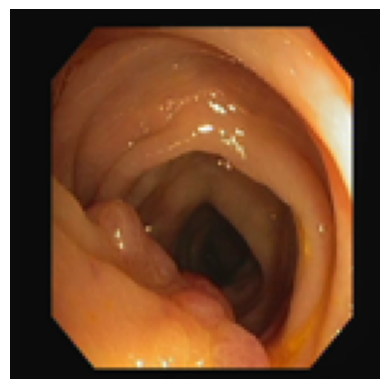

In [116]:
data_og = []

for i in range(612):
  image = Image.open("/root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1/PNG/Original/" + str(i+1) + ".png")
  image_resized = image.resize((128, 128))
  image_array = np.array(image_resized)
  data_og.append(image_array)

plt.imshow(data_og[1])
plt.axis('off')  # Hide axes
plt.show()

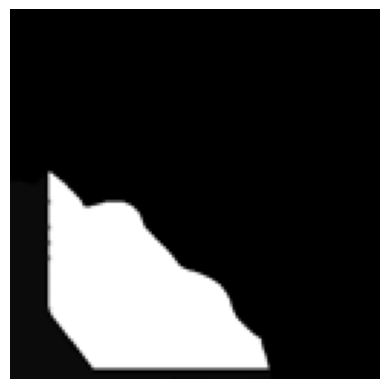

In [114]:
data_gt = []
for i in range(612):
  image = Image.open("/root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1/PNG/Ground Truth/" + str(i+1) + ".png")
  image_resized = image.resize((128, 128))
  image_array = np.array(image_resized)
  data_gt.append(image_array)

plt.imshow(data_gt[1])
plt.axis('off')  # Hide axes
plt.show()

In [117]:
print(len(data_og))
print(len(data_gt))

612
612


In [133]:
norm_gt = []
norm_og = []

for img_gt in data_gt:
  norm_gt.append(img_gt/255)

for img_og in data_og:
  norm_og.append(img_og/255)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
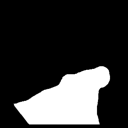

In [138]:
data_gt[13]

array([[[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       ...,

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)
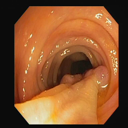

In [139]:
data_og[13]

### U-Net

https://arxiv.org/pdf/1505.04597v1

In [151]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(input)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(3, (1, 1), activation="sigmoid" )(d4)

    return Model(inputs, outputs)

In [152]:
unet_model = unet()
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
tensor_og = np.array(norm_og)
tensor_gt = np.array(norm_gt)

In [155]:
print(tensor_og.shape)
print(tensor_gt.shape)

smaller_gt = tensor_gt[:300]
smaller_og = tensor_og[:300]

print(smaller_gt.shape)
print(smaller_og.shape)

(612, 128, 128, 3)
(612, 128, 128, 3)
(300, 128, 128, 3)
(300, 128, 128, 3)


In [156]:
print(tensor_og.shape)
print(tensor_gt.shape)
unet_model.fit(smaller_og, smaller_gt, epochs=3, batch_size=10)

(612, 128, 128, 3)
(612, 128, 128, 3)
Epoch 1/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 537s 18s/step - accuracy: 0.3876 - loss: 0.3566
Epoch 2/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 527s 17s/step - accuracy: 0.3439 - loss: 0.2698
Epoch 3/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 562s 17s/step - accuracy: 0.4483 - loss: 0.2539


My results are not as high quality as the original U-Net's because I used a smaller amount of the dataset for time constraint reasons. I think more epochs and using more of the data would have provided better results. Still, the architecture really does work and I achieved an accuracy of $44.8\%$ and loss of $0.254$ by the end. Looking at the images I think it would be interesting to look into whether adding an edge detection filter as input would have been beneficial, as the polyps do tend to have a clear edge.